In [54]:
from pathlib import Path
import argparse
import json
import math
import os
import random
import signal
import subprocess
import sys
import time

from PIL import Image, ImageOps, ImageFilter
from torch import nn, optim
import torch
#!pip 
import torchvision
import torchvision.transforms as transforms
import monai

In [2]:
# 여기서 정의하는 것 

In [26]:
class class_args():
     def __init__(self):
            self.data = Path('/scratch/connectome/mieuxmin/UKB_t1_MNI')
            self.workers =8 #'number of data loader workers'
            self.epochs=1000 #'number of total epochs to run'
            self.batch_size= 2048 #'mini-batch size'
            self.learning_rate_weights =0.2 #'base learning rate for weights'
            self.learning_rate_biases =0.0048 #'base learning rate for biases and batch norm parameters'
            self.weight_decay=1e-6 #'weight decay'
            self.lambd =0.0051 #'weight on off-diagonal terms'
            self.projector='8192-8192-8192' #'projector MLP'
            self.print_freq=100 #'print frequency'
            self.checkpoint_dir='./checkpoint/' #'path to checkpoint directory'

In [27]:
def main():
    args = class_args #다른점
    args.ngpus_per_node = torch.cuda.device_count() #srun 지정된 갯수만 큼 된다
    if 'SLURM_JOB_ID' in os.environ:
        print("USING MULTI-NODE")
        # single-node and multi-node distributed training on SLURM cluster
        # requeue job on SLURM preemption
        signal.signal(signal.SIGUSR1, handle_sigusr1)
        signal.signal(signal.SIGTERM, handle_sigterm)
        # find a common host name on all nodes
        # assume scontrol returns hosts in the same order on all nodes
        cmd = 'scontrol show hostnames ' + os.getenv('SLURM_JOB_NODELIST')
        stdout = subprocess.check_output(cmd.split())
        host_name = stdout.decode().splitlines()[0]
        args.rank = int(os.getenv('SLURM_NODEID')) * args.ngpus_per_node
        args.world_size = int(os.getenv('SLURM_NNODES')) * args.ngpus_per_node
        args.dist_url = f'tcp://{host_name}:58472'
    else: #일단은 이것만 봐도 될듯??? (slurm job array가 없다고 가정하고 일단은 돌리는 것이 목적이니)
        # single-node distributed training
        args.rank = 0
        args.dist_url = 'tcp://localhost:58472'
        args.world_size = args.ngpus_per_node
    torch.multiprocessing.spawn(main_worker, (args,), args.ngpus_per_node)

In [28]:
#참조, 위에서 있는 것들이 어떤 것인지 보자
args = class_args()
args.ngpus_per_node = torch.cuda.device_count()
args.ngpus_per_node, 'SLURM_JOB_ID' in os.environ, signal.SIGUSR1

(8, False, <Signals.SIGUSR1: 10>)

In [95]:
#example : `cuda:0` ?? 
#
def main_worker(gpu, args):
    args.rank += gpu   #i.e. rank = rank + gpu(왜 이렇게 하는지는 모르겠다....)
    torch.distributed.init_process_group(
        backend='nccl', init_method=args.dist_url,
        world_size=args.world_size, rank=args.rank)

    if args.rank == 0: #i.e. if gpu =0 and (원래) args.rank = 0 (?)
        args.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        stats_file = open(args.checkpoint_dir / 'stats.txt', 'a', buffering=1)
        print(' '.join(sys.argv))
        print(' '.join(sys.argv), file=stats_file)

    torch.cuda.set_device(gpu)
    torch.backends.cudnn.benchmark = True

    model = BarlowTwins(args).cuda(gpu)
    model = nn.SyncBatchNorm.convert_sync_batchnorm(model)
    param_weights = []
    param_biases = []
    for param in model.parameters():
        if param.ndim == 1:
            param_biases.append(param)
        else:
            param_weights.append(param)
    parameters = [{'params': param_weights}, {'params': param_biases}]
    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[gpu])
    optimizer = LARS(parameters, lr=0, weight_decay=args.weight_decay,
                     weight_decay_filter=True,
                     lars_adaptation_filter=True)

    # automatically resume from checkpoint if it exists
    if (args.checkpoint_dir / 'checkpoint.pth').is_file():
        ckpt = torch.load(args.checkpoint_dir / 'checkpoint.pth',
                          map_location='cpu')
        start_epoch = ckpt['epoch']
        model.load_state_dict(ckpt['model'])
        optimizer.load_state_dict(ckpt['optimizer'])
    else:
        start_epoch = 0

    dataset = torchvision.datasets.ImageFolder(args.data / 'train', Transform())
    sampler = torch.utils.data.distributed.DistributedSampler(dataset)
    assert args.batch_size % args.world_size == 0
    per_device_batch_size = args.batch_size // args.world_size
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=per_device_batch_size, num_workers=args.workers,
        pin_memory=True, sampler=sampler)

    start_time = time.time()
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(start_epoch, args.epochs):
        sampler.set_epoch(epoch)
        for step, ((y1, y2), _) in enumerate(loader, start=epoch * len(loader)):
            y1 = y1.cuda(gpu, non_blocking=True)
            y2 = y2.cuda(gpu, non_blocking=True)
            adjust_learning_rate(args, optimizer, loader, step)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                loss = model.forward(y1, y2)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            if step % args.print_freq == 0:
                if args.rank == 0:
                    stats = dict(epoch=epoch, step=step,
                                 lr_weights=optimizer.param_groups[0]['lr'],
                                 lr_biases=optimizer.param_groups[1]['lr'],
                                 loss=loss.item(),
                                 time=int(time.time() - start_time))
                    print(json.dumps(stats))
                    print(json.dumps(stats), file=stats_file)
        if args.rank == 0:
            # save checkpoint
            state = dict(epoch=epoch + 1, model=model.state_dict(),
                         optimizer=optimizer.state_dict())
            torch.save(state, args.checkpoint_dir / 'checkpoint.pth')
    if args.rank == 0:
        # save final model
        torch.save(model.module.backbone.state_dict(),
                   args.checkpoint_dir / 'resnet50.pth')

# 데이터 하나로 가지고 놀기

before transform
(182, 218, 182)


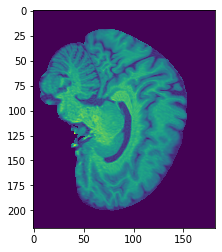

after transform
(1, 182, 218, 182)


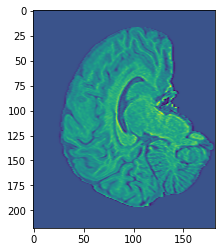

In [222]:
import matplotlib.pyplot as plt
from monai.transforms import ScaleIntensity # scaling 하는 것
im_filename = "/scratch/connectome/mieuxmin/UKB_t1_MNI/6025016_T1_brain_to_MNI.nii.gz"

img,meta = LoadImage()(filename = im_filename)

#SCale
scaled_img = ScaleIntensity()(img)


#trans 
final_img = ScaleIntensity()(img)
final_img = AddChannel()(final_img)
final_img = RandFlip(prob = 0.5)(final_img)
final_img = RandGaussianSharpen(sigma1_x=(0.1, 1.0), sigma1_y=(0.1, 1.0), sigma1_z=(0.1, 1.0), sigma2_x=0.1, sigma2_y=0.1, sigma2_z=0.1,prob=1.0)(final_img)
final_img = ResizeWithPadOrCrop(spatial_size = (182,218,182), method = "symmetric", mode = "constant")(final_img)
final_img = NormalizeIntensity()(final_img)
#compose
#final_img = Compose([
#            #normalize , flip, blur, noise, cutout, crop
#            LoadImage()(image_only=True),
#            ScaleIntensity(), AddChannel(),
#            RandFlip(prob = 0.5),
#            RandGaussianSharpen(sigma1_x=(0.1, 1.0), sigma1_y=(0.1, 1.0), sigma1_z=(0.1, 1.0), sigma2_x=0.1, sigma2_y=0.1, sigma2_z=0.1,prob=0.5),
#            ResizeWithPadOrCrop(spatial_size = (170,100,150), #self.img_shape, 
#                                method = "symmetric", mode = "constant"),ToTensor()
            
#        ])


#final_img= monai.transforms.ResizeWithPadOrCrop(spatial_size = (170,100,150), method = "symmetric", mode = "constant")(channel_add_img)

print("before transform")
print(scaled_img.shape)
plt.imshow(scaled_img[100])
plt.show()

print("after transform")
print(final_img.shape)
plt.imshow(final_img[0][100])
plt.show()


In [221]:
final_img = ToTensor()(final_img)
print(type(final_img))

<class 'monai.data.meta_tensor.MetaTensor'>


# Datasets 정의 

- Barlow twins 2D 형태에서/ augmentation부분은 yaware참고(MONAI버전으로) / Dataset부분은 3D VAE따라

In [235]:
##define dataset (through kinda wrapping over the ImageDataset)
def UKB_T1(data_path, split, transform, **kwargs):
    """주의 : train/test split rate : 0.75로 preset (희환쌤 코드 처럼 분리할 수도 있을 것 같으나, 이것은 나중에 하자 )"""
    
    #list imgs list inside the directory, with suffixes ending in .gz (list of nii.gz files) ==> sorted 
    imgs = sorted([f for f in Path(data_path).iterdir() if f.suffix == '.gz']) # f.suffixes로 하면 nii.gz까지 다 있으나, .crop도 suffix로 인정되어 복잡해짐..
    
    #TRAIN_TEST SPLIT (take first 75% or last 25% of iamge list depending on split)
    imgs = imgs[:int(len(imgs)*0.75)] if split == "train" else imgs[int(len(imgs)*0.75): ] #i.e. 앞의 75% if train/뒤의 25% if test
                        #list of subject directories (PosixPath) to use
    
    
    """labels도 위의 두 줄처럼럼 어떻게 해서 하기
        #imgs와 order 이 같아야하는 것을 주의하면서! 근데 원래 CELEBA도 40짜리 label을 가져서, 우리도 label찾아서 해야할 듯!
        ordering이 맞아야한다는 것을 주의하기!
        일단은 그냥 똑같은 shape를 가진 0으로된np  array로 하자"""
    lbls = np.zeros(len(imgs))

    return ImageDataset(image_files=imgs, labels = lbls, transform = transform)
    

In [202]:
imgs = sorted([f for f in Path(data_path).iterdir() if f.suffix == '.gz'])
imgs

[PosixPath('/scratch/connectome/mieuxmin/UKB_t1_MNI/2003157_T1_brain_to_MNI.nii.gz'),
 PosixPath('/scratch/connectome/mieuxmin/UKB_t1_MNI/3003063_T1_brain_to_MNI.nii.gz'),
 PosixPath('/scratch/connectome/mieuxmin/UKB_t1_MNI/3007523_T1_brain_to_MNI.nii.gz'),
 PosixPath('/scratch/connectome/mieuxmin/UKB_t1_MNI/5976561_T1_brain_to_MNI.nii.gz'),
 PosixPath('/scratch/connectome/mieuxmin/UKB_t1_MNI/6025016_T1_brain_to_MNI.nii.gz')]

In [233]:
from monai.data import ImageDataset
from monai.transforms import *


class Transform:
    def __init__(self):
        
        self.transform = monai.transforms.Compose([
            #normalize , flip, blur, noise, cutout, crop
            ScaleIntensity(), AddChannel(),
            RandFlip(prob = 0.5),
            RandGaussianSharpen(sigma1_x=(0.1, 1.0), sigma1_y=(0.1, 1.0), sigma1_z=(0.1, 1.0), sigma2_x=0.1, sigma2_y=0.1, sigma2_z=0.1,prob=0.5),
            ResizeWithPadOrCrop(spatial_size =  (182,218,182), method = "symmetric", mode = "constant"),
            NormalizeIntensity()
            ,ToTensor()
        ])
        
   
        #어디에 뭐가 들어있는지 확인하기 위해서, (182,20,182)로 함
        self.transform_prime = monai.transforms.Compose([
            #normalize , flip, blur, noise, cutout, crop
            ScaleIntensity(), AddChannel(),
            RandFlip(prob = 0.5),
            RandGaussianSharpen(sigma1_x=(0.1, 1.0), sigma1_y=(0.1, 1.0), sigma1_z=(0.1, 1.0), sigma2_x=0.1, sigma2_y=0.1, sigma2_z=0.1,prob=0.5),
            ResizeWithPadOrCrop(spatial_size =  (182,218,182), method = "symmetric", mode = "constant"),
            NormalizeIntensity()
            ,ToTensor()
        ])
        
         
            
    def __call__(self, x):
        y1 = self.transform(x)
        y2 = self.transform_prime(x)
        return y1,y2

In [237]:
import numpy as np
data_path = "/scratch/connectome/mieuxmin/UKB_t1_MNI"
dataset = UKB_T1(data_path = data_path,split = "train", transform = Transform())
print(type(dataset[0]))
#image1, image2의 shapes
#dataset[1][0][0].shape
len(dataset[0])

<class 'tuple'>


2

In [239]:
data_path = "/scratch/connectome/mieuxmin/UKB_t1_MNI"
dataset = UKB_T1(data_path = data_path,split = "train", transform = Transform())
print(type(dataset[0][0]))
print(dataset[0][1])
#image1, image2의 shapes
dataset[0][0][0].shape, dataset[0][0][1].shape

<class 'tuple'>
0.0


((1, 182, 218, 182), (1, 182, 20, 182))

In [ ]:
dataset.type

In [ ]:
##define dataloader class 
from monai.transforms import *

##CHANGE IT!
class BT_Dataset(LightningDataModule):
    """
    PyTorch Lightning data module 

    Args:
        data_dir: root directory of your dataset.
        train_batch_size: the batch size to use during training.
        val_batch_size: the batch size to use during validation.
        patch_size: the size of the crop to take from the original images.
        num_workers: the number of parallel workers to create to load data
            items (see PyTorch's Dataloader documentation for more details).
        pin_memory: whether prepared items should be loaded into pinned memory
            or not. This can improve performance on GPUs.
    """

    def __init__(
        self,
        data_path: str,
        train_batch_size: int = 8,
        val_batch_size: int = 8,
        patch_size: Union[int, Sequence[int]] = (256, 256),
        num_workers: int = 0,
        pin_memory: bool = False,
        img_shape: list =[90,90,90],
        **kwargs,
    ):
        super().__init__()

        self.data_dir = data_path
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.patch_size = patch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.img_shape = img_shape

    def setup(self, stage: Optional[str] = None) -> None:
        

        ##########이 파트를 바꾸기!
#       =========================  UKB_T1 Dataset #CelebA Dataset  =========================
        
    
        """IMPLEMENT WITH 정윤쌤 코드"""
        train_transforms = Compose([ScaleIntensity(), AddChannel(), 
                 ResizeWithPadOrCrop(spatial_size = self.img_shape, method = "symmetric", mode = "constant"),
                 ToTensor()]) 
        
        val_transforms = Compose([ScaleIntensity(), AddChannel(), 
                 ResizeWithPadOrCrop(spatial_size = self.img_shape, method = "symmetric", mode = "constant"),
                 ToTensor()]) 

        
        #UKB_T1 function (not class)를 썼다!
        self.train_dataset = UKB_T1(
            data_path = self.data_dir,
            split = 'train',
            transform = train_transforms,
        )
        
        self.val_dataset = UKB_T1(
            data_path = self.data_dir,
            split = 'test',
            transform = val_transforms,
        )
        #self.train_dataset = MyCelebA(
        #    self.data_dir,
        #    split='train',
        #    transform=train_transforms,
        #    download=False,
        #)
        
        ## Replace CelebA with your dataset
        #self.val_dataset = MyCelebA(
        #    self.data_dir,
        #    split='test',
        #    transform=val_transforms,
        #    download=False,
        #)
#       ===============================================================
    
    
    """밑에 파트는 바꿀필요 없다 ㅋㅋㅋㅋ """
    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )

    def val_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=self.val_batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=self.pin_memory,
        )
    
    def test_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=144,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )
     